Bailey Gallagher and Jake Reilley
Machine Learning Final Project

In [82]:
import numpy as np
np.random.seed(0)
import mltools as ml
import matplotlib.pyplot as plt   # use matplotlib for plotting with inline plots
import imblearn
import sklearn 
import pandas
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.preprocessing import StandardScaler 
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# KNN CLASSIFY
X = pandas.read_csv('Xtrain.csv')
Y = pandas.read_csv('Ytrain.csv')

# focus only on the feature values for X (not the id, country name, or year) and the predicted values of Y
# cast as floats (the strings that were read in originally mess up the types of the whole array)
Xtrain, Ytrain = (X.iloc[:,3:].astype(float), Y.iloc[:,1:].astype(float))

# Tells numpy not to print everything in scientific notation 
np.set_printoptions(suppress=True)


# count number of missing values. They show up as nan (not a number) in numpy
#print(np.count_nonzero(np.isnan(Xtrain)))
#print(np.count_nonzero(np.isnan(Ytrain)))

# Replace the missing values by taking the mean of the column PER COUNTRY. This uses the full X data so we have access
# to the country names
Xnew = X.fillna(X.groupby('Area').transform('mean'))

# If there are still NaNs (if a country has all NaNs for a particular feature) replace them with the overall average
# (this can probably be improved by using a nearest neighbor method)
Xnew.fillna(Xnew.iloc[:,2:].mean().iloc[0], inplace=True)

# Add the Area column to the Y data so we can use it for grouping
Ytrain['Area'] = X['Area']

# Replace real values with per group mean
Ynew = Ytrain.iloc[:,0:2].fillna(Ytrain.groupby('Area').transform('mean'))
Ynew.fillna(Ynew.iloc[:,:].mean().iloc[0], inplace=True)


# Replace categorical values based on numerical values
Ynew[Ytrain.columns[2]] = Ytrain[Ytrain.columns[2]]
Ynew.loc[Ynew[Ynew.columns[0]] >= 50, Ynew.columns[2]].fillna(1, inplace=True) # NaNs = 1 when col0 > 50%
Ynew.loc[Ynew[Ynew.columns[1]] >= 50, Ynew.columns[2]].fillna(1, inplace=True) # NaNs = 1 when col1 > 50%
Ynew[Ynew.columns[2]].fillna(0, inplace=True)  # otherwise NaNs = 0

#start training 

sm = SMOTE(random_state = 2)
Ynew = np.asarray(Ynew.iloc[:,2:])
Xnew = np.asarray(Xnew.iloc[:,3:])

[Xtrain,Xval,Ytrain,Yval] = ml.splitData(Xnew,Ynew,0.75) 
#print(Xnew)
Xtr_res, Ytr_res = sm.fit_resample(Xtrain, Ytrain.ravel()) 
# print out the number of each class
(y_class, counts) = np.unique(Ytr_res, return_counts=True)
class_frequencies = np.asarray((y_class, counts)).T
# should be an even split!
#scaling X

scale = StandardScaler().fit(Xtr_res)
Xtr_res_scaled = scale.transform(Xtr_res)
Xval_scaled = scale.transform(Xval)
Xtr_res_scaled = Xtr_res_scaled[:400,:20]
Xval_scaled = Xval_scaled[:400,:20]
#data cleaning done 
# making my knn classifier
knn = ml.knn.knnClassify()
k=4
knn.train(Xtr_res_scaled, Ytr_res.ravel()[:400], k)
pred_tr = knn.predict(Xtr_res_scaled)
  
# see how well we do on the validation data
pred_val = knn.predict(Xval_scaled) 
  
# print classification reports
print("Performance on Training Data:")
print(classification_report(Ytrain[:400],pred_tr))

print("\n Performance on Validation Data:")
print(classification_report(Yval[:400], pred_val))
Xte = pandas.read_csv('Xtest.csv')

# Clean test data in same manner as training data 
Xte_cleaned = Xte.fillna(Xte.groupby('Area').transform('mean'))
Xte_cleaned.fillna(Xte_cleaned.iloc[:,2:].mean().iloc[0], inplace=True)

# Focus only on the feature values for test data (match training data selection)
Xte_cleaned = Xte_cleaned.iloc[:, 3:].astype(float)

# Scale the test data
Xte_scaled = scale.transform(Xte_cleaned)
Xte_scaled = Xte_scaled[:, :20]  # Ensure the same number of features as used in training

# Predict a probability of class 1
#Yte = np.vstack((np.arange(Xte.shape[0]), knn.predictSoft(Xte_scaled)[:,1])).T

# Output a file with two columns, a unique ID and a probability of class 1
#print(Yte.shape)
#np.savetxt('Y_submitKNNClassify.csv', Yte, fmt='%d,%.2f', header="id,Prevalence of severe food insecurity in the total population (percent) (3-year average),Prevalence of moderate or severe food insecurity in the total population (percent) (3-year average),Food Insecure Categorical", delimiter=',')
#print("FIN")


Performance on Training Data:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       360
         1.0       0.97      0.88      0.92        40

    accuracy                           0.98       400
   macro avg       0.98      0.94      0.96       400
weighted avg       0.98      0.98      0.98       400


 Performance on Validation Data:
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96       203
         1.0       0.66      0.78      0.71        27

    accuracy                           0.93       230
   macro avg       0.81      0.86      0.83       230
weighted avg       0.93      0.93      0.93       230



For my Classification K-Nearest Neighbors model,I used mlTools knnCLassify constructor, and their training and predict functions. I used imblearn's oversampling methods and SkLearn's scaling capabilities. I first checked to see how many "ones" were seen compared to zeros. It was a very low number, only about five percent. I decided to do oversampling in order to get the ratio closer to 50/50. Before I did oversampling, I had a relatively low error rate with barely any adjustments to the basic KNN model, but I realized this was because my learner could always predict a 0 and had a very good chance of being right. I ran my KNN model with varying k-values (1,2,3,4,5,10,20) ,as well as different subsections of the features of X. I got the best results with keeping my neighbor amount small, with 3 or 4 seeming like viable options. As far as what features of X to include, I ran my model with different sections of X, and higher number of features did better. This is probably because I have so many Y-values. My model performed best with 20 columns of features. With twenty featires pf X chosen, I then adjusted the amount of rows of data I was training on. I had my best results at 400 rows. 

In [70]:
import numpy as np
np.random.seed(0)
import mltools as ml
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline

# SEVERE POVERTY KNN REGRESSION MODEL
# Load data
X = pd.read_csv('Xtrain.csv')
Y = pd.read_csv('Ytrain.csv')

# Focus only on the feature values for X and the predicted values of Y
Xtrain = X.iloc[:, 3:].astype(float)
Ytrain = Y.iloc[:, 1:].astype(float)

# Replace missing values
Xnew = X.fillna(X.groupby('Area').transform('mean'))
Xnew.fillna(Xnew.iloc[:, 2:].mean(), inplace=True)

Ytrain['Area'] = X['Area']
Ynew = Ytrain.iloc[:, 0:2].fillna(Ytrain.groupby('Area').transform('mean'))
Ynew.fillna(Ynew.iloc[:, :].mean(), inplace=True)

Ynew[Ytrain.columns[2]] = Ytrain[Ytrain.columns[2]]
Ynew.loc[Ynew[Ynew.columns[0]] >= 50, Ynew.columns[2]].fillna(1, inplace=True)
Ynew.loc[Ynew[Ynew.columns[1]] >= 50, Ynew.columns[2]].fillna(1, inplace=True)
Ynew[Ynew.columns[2]].fillna(0, inplace=True)

# Check for NaNs
#print(np.count_nonzero(np.isnan(Xnew.iloc[:, 3:].astype(float))))
#print(np.count_nonzero(np.isnan(Ynew.iloc[:, :3])))

#to numPy
Xnew = np.asarray(Xnew.iloc[:, 3:])
#PREDICTING SEVERE
Ynew = np.asarray(Ynew.iloc[:, 1])
#print(Ynew)
# Split data
Xtrain, Xval, Ytrain, Yval = train_test_split(Xnew, Ynew, test_size=0.25, random_state=1)

#scaling X
scale = StandardScaler().fit(Xtrain)
Xtrain_scaled = scale.transform(Xtrain)
Xval_scaled = scale.transform(Xval)

def MSE(y_true, y_hat):
    diff = y_true - y_hat
    diff2 = diff * diff
    return np.mean(diff2)
    
#switching to SKlearn KNN because my mltools one was BAD
# find Hyperparameter w/ GridSearchCV
param_grid = {'n_neighbors': np.arange(1, 51)}
#construct model
sevknn = KNeighborsRegressor()

# Grid Search with cross-validation
grid_search = GridSearchCV(sevknn, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(Xtrain_scaled, Ytrain)

#find best hyperparameters
best_k = grid_search.best_params_['n_neighbors']

#train with best K
sevknn = KNeighborsRegressor(n_neighbors=best_k)
sevknn.fit(Xtrain_scaled, Ytrain)

YtrainHat = sevknn.predict(Xtrain_scaled)
YvalHat = sevknn.predict(Xval_scaled)
#find error num
errT = MSE(Ytrain, YtrainHat)
errV = MSE(Yval, YvalHat)
print("MSE Training:", errT)
print("MSE Validation:", errV)

## now reading in XTest, model is going to predict on MODERATE INSECURITY
Xte = pd.read_csv('Xtest.csv')
# Clean test data in same manner as training data 
Xte = pd.DataFrame(Xte)
Xte_cleaned = Xte.fillna(Xte.groupby('Area').transform('mean'))
Xte_cleaned.fillna(Xte_cleaned.iloc[:,2:].mean().iloc[0], inplace=True)

# Focus only on the feature values for test data (match training data selection)
Xte_cleaned = Xte_cleaned.iloc[:, 3:].astype(float)

# Scale the test data
Xte_scaled = scale.transform(Xte_cleaned)

# Predict a probability of class 1
#print(Xte_scaled.shape)
#Yte_pred = sevknn.predict(Xte_scaled)
# Output a file with two columns, a unique ID and the predicted value
#Yte = np.vstack((np.arange(Xte.shape[0]), Yte_pred)).T
#np.savetxt('Y_submitKNNRegressSev.csv', Yte, '%d, %.2f', header='Unique Id,Prediction', delimiter=',', comments='')

#print("FIN")

MSE Training: 0.0
MSE Validation: 0.9335809175989374


In [71]:
import numpy as np
np.random.seed(0)
import mltools as ml
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
%matplotlib inline
#MODERATE POVERTY LEVEL KNN REGRESSION LEARNER
# Load data
X = pd.read_csv('Xtrain.csv')
Y = pd.read_csv('Ytrain.csv')

# Focus only on the feature values for X and the predicted values of Y
Xtrain = X.iloc[:, 3:].astype(float)
Ytrain = Y.iloc[:, 1:].astype(float)

# Replace missing values
Xnew = X.fillna(X.groupby('Area').transform('mean'))
Xnew.fillna(Xnew.iloc[:, 2:].mean(), inplace=True)

Ytrain['Area'] = X['Area']
Ynew = Ytrain.iloc[:, 0:2].fillna(Ytrain.groupby('Area').transform('mean'))
Ynew.fillna(Ynew.iloc[:, :].mean(), inplace=True)

Ynew[Ytrain.columns[2]] = Ytrain[Ytrain.columns[2]]
Ynew.loc[Ynew[Ynew.columns[0]] >= 50, Ynew.columns[2]].fillna(1, inplace=True)
Ynew.loc[Ynew[Ynew.columns[1]] >= 50, Ynew.columns[2]].fillna(1, inplace=True)
Ynew[Ynew.columns[2]].fillna(0, inplace=True)

# Check for NaNs
#print(np.count_nonzero(np.isnan(Xnew.iloc[:, 3:].astype(float))))
#print(np.count_nonzero(np.isnan(Ynew.iloc[:, :3])))

#to numPy
Xnew = np.asarray(Xnew.iloc[:, 3:])
#predicting MODERATE
#print(Ynew)
Ynew = np.asarray(Ynew.iloc[:, 0])
#print(Ynew)
# Split data
Xtrain, Xval, Ytrain, Yval = train_test_split(Xnew, Ynew, test_size=0.25, random_state=0)

#scaling X
scale = StandardScaler().fit(Xtrain)
Xtrain_scaled = scale.transform(Xtrain)
Xval_scaled = scale.transform(Xval)

def MSE(y_true, y_hat):
    diff = y_true - y_hat
    diff2 = diff * diff
    return np.mean(diff2)
    
#switching to SKlearn KNN because my mltools one was BAD
# find Hyperparameter w/ GridSearchCV
param_grid = {'n_neighbors': np.arange(1, 51)}
#construct model
modknn = KNeighborsRegressor()

# Grid Search with cross-validation
grid_search = GridSearchCV(modknn, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(Xtrain_scaled, Ytrain)

#find best hyperparameters
best_k = grid_search.best_params_['n_neighbors']

#train with best K
modknn = KNeighborsRegressor(n_neighbors=best_k)
modknn.fit(Xtrain_scaled, Ytrain)

YtrainHat = modknn.predict(Xtrain_scaled)
YvalHat = modknn.predict(Xval_scaled)
#find error num
errT = MSE(Ytrain, YtrainHat)
errV = MSE(Yval, YvalHat)
print("MSE Training:", errT)
print("MSE Validation:", errV)

## now reading in XTest, model is going to predict on MODERATE INSECURITY
Xte = pd.read_csv('Xtest.csv')
# Clean test data in same manner as training data 
Xte_cleaned = Xte.fillna(Xte.groupby('Area').transform('mean'))
Xte_cleaned.fillna(Xte_cleaned.iloc[:,2:].mean().iloc[0], inplace=True)

# Focus only on the feature values for test data (match training data selection)
Xte_cleaned = Xte_cleaned.iloc[:, 3:].astype(float)

# Scale the test data
Xte_scaled = scale.transform(Xte_cleaned)

# Predict a probability of class 1
#print(Xte_scaled.shape)
#Yte_pred = knn.predict(Xte_scaled)
# Output a file with two columns, a unique ID and the predicted value
#Yte = np.vstack((np.arange(Xte.shape[0]), Yte_pred)).T
#np.savetxt('Y_submitKNNRegressMod.csv', Yte, '%d, %.2f', header='Unique Id,Prediction', delimiter=',', comments='')

#print("FIN")

MSE Training: 0.0
MSE Validation: 0.5323490338766181


For my regression nearest neighbor, I first tried using mlTools library with simialr logic to the one above. I got a HORRIBLE model with MSE's that were all above 200. This was after I had already processed the data. I did this by taking the average across columns to fill in missing values, similar to my KNN CLassifier.I did not oversample the data, since my Y's were not binary.I think now that if I had, my mlTools model would have worked better. I ended up using SKLearn library, and read about ways to improve my model. I used a gridSearch method to find the best hyperparamters and K-values to choose. I needed to use SKlearn's KNN constructor and methods then. This model seemed to perform very well on my testing and training data compared to my other models. THis is probably bc I used existing algorithms/methods to find what features to use and my K-value, instead of the rudimentary method I used in the KNN classify (Looping through different K-values and subsections of the feature matrix. 

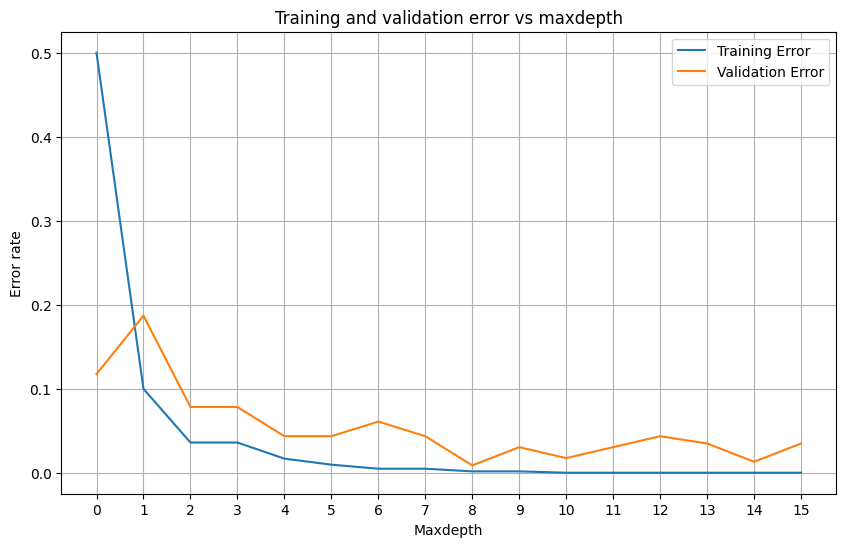

In [72]:
import numpy as np
np.random.seed(0)
import mltools as ml
import matplotlib.pyplot as plt   # use matplotlib for plotting with inline plots
import imblearn
import sklearn 
import pandas
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.preprocessing import StandardScaler 
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# Xtrain.csv
#X = np.genfromtxt('data/X_train.txt', delimiter=None) 
# X = np.genfromtxt('Xtrain.csv', delimiter=',') 
# text_Y = np.genfromtxt('data/Y_train.txt', delimiter=None) 

X = pandas.read_csv('Xtrain.csv')
Y = pandas.read_csv('Ytrain.csv')

# focus only on the feature values for X (not the id, country name, or year) and the predicted values of Y
# cast as floats (the strings that were read in originally mess up the types of the whole array)
Xtrain, Ytrain = (X.iloc[:,3:].astype(float), Y.iloc[:,1:].astype(float))

# Tells numpy not to print everything in scientific notation 
np.set_printoptions(suppress=True)


# count number of missing values. They show up as nan (not a number) in numpy
#print(np.count_nonzero(np.isnan(Xtrain)))
#print(np.count_nonzero(np.isnan(Ytrain)))

# Replace the missing values by taking the mean of the column PER COUNTRY. This uses the full X data so we have access
# to the country names
Xnew = X.fillna(X.groupby('Area').transform('mean'))

# If there are still NaNs (if a country has all NaNs for a particular feature) replace them with the overall average
# (this can probably be improved by using a nearest neighbor method)
Xnew.fillna(Xnew.iloc[:,2:].mean().iloc[0], inplace=True)

# Add the Area column to the Y data so we can use it for grouping
Ytrain['Area'] = X['Area']

# Replace real values with per group mean
Ynew = Ytrain.iloc[:,0:2].fillna(Ytrain.groupby('Area').transform('mean'))
Ynew.fillna(Ynew.iloc[:,:].mean().iloc[0], inplace=True)


# Replace categorical values based on numerical values
Ynew[Ytrain.columns[2]] = Ytrain[Ytrain.columns[2]]
Ynew.loc[Ynew[Ynew.columns[0]] >= 50, Ynew.columns[2]].fillna(1, inplace=True) # NaNs = 1 when col0 > 50%
Ynew.loc[Ynew[Ynew.columns[1]] >= 50, Ynew.columns[2]].fillna(1, inplace=True) # NaNs = 1 when col1 > 50%
Ynew[Ynew.columns[2]].fillna(0, inplace=True)  # otherwise NaNs = 0

#print(np.count_nonzero(np.isnan(Xnew.iloc[:,3:].astype(float))))
#print(np.count_nonzero(np.isnan(Ynew.iloc[:,:3])))
#print(Ynew.iloc[:,2:].shape) 
#print(Xnew.iloc[:,3:].shape)
#print(Ynew.iloc[:,2:])

#start training 

sm = SMOTE(random_state = 2)
Ynew = np.asarray(Ynew.iloc[:,2:])
Xnew = np.asarray(Xnew.iloc[:,3:])

[Xtrain,Xval,Ytrain,Yval] = ml.splitData(Xnew,Ynew,0.75) 
Xtr_res, Ytr_res = sm.fit_resample(Xtrain, Ytrain.ravel()) 
# print out the number of each class
(y_class, counts) = np.unique(Ytr_res, return_counts=True)
class_frequencies = np.asarray((y_class, counts)).T
# should be an even split!
#scaling X
scale = StandardScaler().fit(Xtr_res)
Xtr_res_scaled = scale.transform(Xtr_res)
Xval_scaled = scale.transform(Xval)
#data cleaning done 
# making my knn classifier

#Xtr_res_scaled, Ytr_res = Xtrain and Ytrain
# making graph to see how my models look: 
train_error =[]
val_error=[]
max_depth_vals = list(range(16))
for max_depth in max_depth_vals:
    learner =  ml.dtree.treeClassify()
    learner.train(Xtr_res_scaled, Ytr_res,maxDepth=max_depth)
    train_pred = learner.predict(Xtr_res_scaled)
    val_pred = learner.predict(Xval_scaled  )
    T_error = 1-np.mean(Ytr_res== train_pred)
    V_error= 1-np.mean(Yval== val_pred)
    train_error.append(T_error)
    val_error.append(V_error)
#print(Ytr_res)
# TODO: plot the training and validation error versus maxDepth
plt.figure(figsize=(10,6))
plt.plot(max_depth_vals,train_error,label="Training Error")
plt.plot(max_depth_vals,val_error, label="Validation Error")
plt.title("Training and validation error vs maxdepth")
plt.xlabel("Maxdepth")
plt.ylabel("Error rate")
plt.xticks(max_depth_vals)
plt.legend()
plt.grid("true")
plt.show()
# best max depth is 9

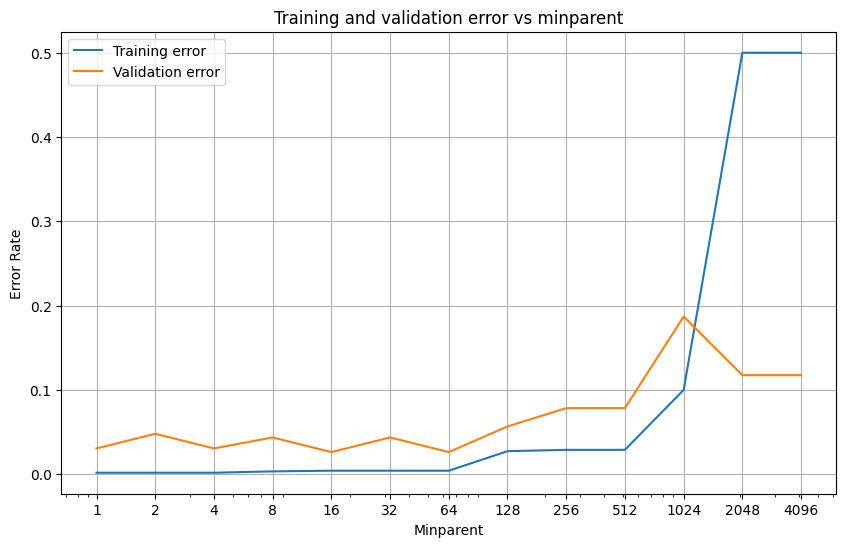

In [73]:
train_error =[]
val_error=[]
min_par_vals = [2**i for i in range(13)]
for min_parents in min_par_vals:
    learner= ml.dtree.treeClassify()
    learner.train(Xtr_res_scaled, Ytr_res,minParent = min_parents, maxDepth=9)
    #ytrain hat
    train_pred = learner.predict(Xtr_res_scaled)
    #yvalhat
    val_pred = learner.predict(Xval_scaled)
    T_error = 1- np.mean(Ytr_res== train_pred)
    V_error= 1- np.mean(Yval== val_pred)
    train_error.append(T_error)
    val_error.append(V_error)
 
# TODO: plot the training and validation error versus maxDepth
plt.figure(figsize=(10,6))
plt.plot(min_par_vals,train_error,label="Training error")
plt.plot(min_par_vals,val_error, label="Validation error")
plt.title("Training and validation error vs minparent")
plt.xlabel("Minparent")
plt.ylabel("Error Rate")
plt.xscale("log")
plt.xticks(min_par_vals,labels=[str(val) for val in min_par_vals])
plt.legend()
plt.grid("true")
plt.show()
#best is minParent = 8

In [74]:
# TODO: retrain your "best" classifier on the whole training dataset
# TODO: retrain your "best" classifier on the whole training dataset
maxDepth=8
minParent=8
bestcla = ml.dtree.treeClassify()
bestcla.train(Xtr_res_scaled, Ytr_res, minParent, maxDepth)
fullpred = bestcla.predict(Xval_scaled)
full_error_rate= 1- np.mean(Yval== val_pred)
full_auc = bestcla.auc(Xval_scaled, Yval)
# TODO: compute error and AUC 
print("error rate on full dataset:", full_error_rate)
print ("AUC on full dataset:", full_auc)

error rate on full dataset: 0.11739130434782608
AUC on full dataset: 0.9917898193760263


In [75]:
#official model and attempts to export data
maxDepth=9
minParent=8
learner = ml.dtree.treeClassify()
learner.train(Xtr_res_scaled, Ytr_res, minParent, maxDepth)
# Load X_test.txt
Xte = pandas.read_csv('Xtest.csv')
Xte = np.asarray(Xte)
Xte_scaled = scale.transform(Xte[:,3:])
# Predict a probability of class 1
#print(Xte[:,1])
#print(Xte)

#Yte = np.vstack((np.arange(Xte.shape[0]), knn.predictSoft(Xte)[:,1])).T 
#Yte = np.vstack((np.arange(Xte.shape[0]), learner.predictSoft(Xte_scaled)[:,1])).T

# Output a file with two columns, a unique ID and a probability of class 1
#np.savetxt('Y_submitDTreeClassify.csv',Yte,'%d, %.2f',header='Unique Id,DIST',delimiter=',')


For decision trees, we used it to implement a classification model. I used oversampling once again, since the percentage of 1's was very low compared to 0's in our y-values. Using SMOTE I evened out the ratio between 0 and 1, and rescaled the data so the X's dimensions wouldnt cause any issues. I started with deciding on a maxDepth value, and the lowest combined training and validation error was 9. This performed the best, so I used that as my maxDepth value when working to predict what the best minParent would be. There wasnt a huge variance in errors between maxDepths {6,7,8,9,10,11...}, so I decided it was safe to not analyze the best minParent across the whole set. I found that the best minParent was 8, and then retrained my whole model with these new values. My error was computed was very low, around 2 percent. The AUC was very very close to 1, so quite good. I did cut down the features of x to about 25 since 40 seemed like a lot, but the run time was very quick at 25 features compared to all of my other models, so I decided to stick with it since I was happy with its predicitons on the data. 

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load data
X = pd.read_csv('Xtrain.csv')
Y = pd.read_csv('Ytrain.csv')

# Focus only on the feature values for X and the predicted values of Y
Xtrain = X.iloc[:, 3:].astype(float)
Ytrain = Y.iloc[:, 1:].astype(float)

# Replace missing values
Xnew = X.fillna(X.groupby('Area').transform('mean'))
Xnew.fillna(Xnew.iloc[:, 2:].mean(), inplace=True)

Ytrain['Area'] = X['Area']
Ynew = Ytrain.iloc[:, 0:2].fillna(Ytrain.groupby('Area').transform('mean'))
Ynew.fillna(Ynew.iloc[:, :].mean(), inplace=True)

Ynew[Ytrain.columns[2]] = Ytrain[Ytrain.columns[2]]
Ynew.loc[Ynew[Ynew.columns[0]] >= 50, Ynew.columns[2]].fillna(1, inplace=True)
Ynew.loc[Ynew[Ynew.columns[1]] >= 50, Ynew.columns[2]].fillna(1, inplace=True)
Ynew[Ynew.columns[2]].fillna(0, inplace=True)

# Convert to numPy arrays
Xnew = np.asarray(Xnew.iloc[:, 3:])
Ynew = np.asarray(Ynew.iloc[:, 1])

# Split data
Xtrain, Xval, Ytrain, Yval = train_test_split(Xnew, Ynew, test_size=0.25, random_state=1)
torch.manual_seed(2)
# Define the neural network model
class Model(nn.Module):
    def __init__(self, in_features=33, h1=10, h2=12, h3=10, h4=12, out_features = 1):  # 1 output feature for regression
        super(Model, self).__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.fc4 = nn.Linear(h3, h4)
        self.out = nn.Linear(h4, out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.out(x)
        return x

# Initialize the model
model = Model()

# Convert data to tensors
Xtrain = torch.FloatTensor(Xtrain)
Ytrain = torch.FloatTensor(Ytrain).view(-1, 1)  # Ensure Ytrain is the correct shape for regression

# Set the criterion to measure error
criterion = nn.MSELoss()

# Select optimizer, lr = learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the model
epochs = 3900  # Number of iterations
losses = []  # Array to keep track of error

for i in range(epochs):
    # Do a forward pass
    Ypred = model(Xtrain)  # Get prediction results
    # Measure error
    loss = criterion(Ypred, Ytrain)
    # Save error
    losses.append(loss.detach().numpy())
    # Print status every 100 epochs
    if i % 100 == 0:
        print(f'Epoch: {i} and loss: {loss}')
    # Do backpropagation to fine-tune the weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## now reading in XTest, model is going to predict on SEVERE
#Xte = pd.read_csv('Xtest.csv')
# Clean test data in same manner as training data 
#Xte_cleaned = Xte.fillna(Xte.groupby('Area').transform('mean'))
#Xte_cleaned.fillna(Xte_cleaned.iloc[:,2:].mean().iloc[0], inplace=True)

# Focus only on the feature values for test data (match training data selection)
#Xte_cleaned = Xte_cleaned.iloc[:, 3:].astype(float)

# Scale the test data
#Xte_scaled = scale.transform(Xte_cleaned)
#Xte_scaled = torch.FloatTensor(Xte_scaled)
# Predict a probability of class 1
#print(Xte_scaled.shape)
#Yte_pred = model.forward(Xte_scaled)
# Output a file with two columns, a unique ID and the predicted value
#Yte = np.vstack(Xte[:,0],Yte_pred).T
#np.savetxt('Y_submitKNNRegressMod.csv', Yte, '%d, %.2f', header='id,Prevalence of severe food insecurity in the total population (percent) (3-year average)', delimiter=',', comments='')

#print("FIN")

Epoch: 0 and loss: 3590.575439453125
Epoch: 100 and loss: 142.02719116210938
Epoch: 200 and loss: 120.88803100585938
Epoch: 300 and loss: 123.1116943359375
Epoch: 400 and loss: 95.40091705322266
Epoch: 500 and loss: 78.4156723022461
Epoch: 600 and loss: 87.3433837890625
Epoch: 700 and loss: 78.48609924316406
Epoch: 800 and loss: 134.39479064941406
Epoch: 900 and loss: 65.23936462402344
Epoch: 1000 and loss: 64.9383316040039
Epoch: 1100 and loss: 68.38191986083984
Epoch: 1200 and loss: 46.44755172729492
Epoch: 1300 and loss: 62.232913970947266
Epoch: 1400 and loss: 69.66204833984375
Epoch: 1500 and loss: 50.38367462158203
Epoch: 1600 and loss: 67.00814056396484
Epoch: 1700 and loss: 50.53470993041992
Epoch: 1800 and loss: 72.63986206054688
Epoch: 1900 and loss: 61.36345672607422
Epoch: 2000 and loss: 60.3515739440918
Epoch: 2100 and loss: 50.79501724243164
Epoch: 2200 and loss: 38.833709716796875
Epoch: 2300 and loss: 42.06609344482422
Epoch: 2400 and loss: 34.91387176513672
Epoch: 2500

For the neural net model, we used SKLearn for the data cleaning, and used simialr methods to what was used on the KNN Regression. For creating our model, we used Pytorch and its built in methods. For the actual neural net, we used a guess method, and then fine-tuned the number of layers and nodes after seeing each of their outputs from our MSE printing. Finally, we got the best error method at an epoch of 3800 with four hidden layers, with a 10,12,10,12 node configuration. We kept all features of X for simplicity at first, once we got to an MSE we liked we attempted to cut down the number of features and oour model became much worse. I think more sophisticated data cleaning could have aided our model and being more intentional in how we chose each feature. We also could have done a loop to see where we found just the best amount of features, just the best number of nodes, and just the best number of hidden layers. We  also could have used Bayesian optimization to better tune our hyperparameters. 

In [67]:
Xte =  pandas.read_csv('Xtest.csv', delimiter=None)
Xte = np.asarray(Xte)
Xte_scaled = scale.transform(Xte[:,3:])
#For mod Regression KNN
Xte_p = pd.DataFrame(Xte)
Xte_cleaned = Xte_p.fillna(Xte_p.groupby(1).transform('mean'))
Xte_cleaned.fillna(Xte_cleaned.iloc[:,2:].mean().iloc[0], inplace=True)
# Focus only on the feature values for test data (match training data selection)
Xte_cleaned = Xte_cleaned.iloc[:, 3:].astype(float)
# Scale the test data
Xte_scaled = scale.transform(Xte_cleaned)
Yte_pred_mod = modknn.predict(Xte_scaled)
Yte_pred_sev = sevknn.predict(Xte_scaled)
# FOR DTREE Processing 
Xte_scaled = scale.transform(Xte[:,3:])
Yte = np.vstack((Xte[:,0],Yte_pred_mod, Yte_pred_sev, learner.predict(Xte_scaled))).T 
#np.savetxt('Ytest.csv', Yte, fmt='%d,%.2f',comments='', header="id,Prevalence of severe food insecurity in the total population (percent) (3-year average),Prevalence of moderate or severe food insecurity in the total population (percent) (3-year average),Food Insecure Categorical", delimiter=',')

Which technique performed best, and why? If you used an ensemble, how did you combine the individual models?

I think that our KNN Regression mdel performed the best. Originally, it was defintiely our worse model when I was using mlTool's methods and not optimizing K and the parameters. The error was so bad that I decided to scrap it and moved over to SKLearn. KNN Regression is where I did the most advanced "fine-tuning" of the model. I used SKLearn's methods to help me choose the best K and hyperparameters. The built in GridSearchCV finds the best possible combination of hyperparameters for you. I also used Grid Search to find the best K value, and got results way better than I could have ever done myself with loops and my own guesses. Overal, I think it makes sense for my KNN Regression to be the best performing model since I relied on established machine learning methods and not just our own ideas of what would perform well and tweaking from there. 

What models do you think worked particularly well for this data, the methods/algorithms that worked poorly, and your hypotheses as to why.

On our "best" combinined models CSV submitted to Kaggle, we scored a .98, which we were happy with. This was using KNN Regression to predict levels of severe and moderate to severe poverty. For our classification, we used our decision tree model. On our decision tree model, we achieved about an 11 percent error rate, which is much lower than our KNN CLassifier where we were only able to correctly classify 1's in the data 65 percent of the time. I believe that the KNN Classifier did so badly partly due to our methods of processing the data. When fillng in blank values, we replaced them with the mean of the column. For KNN, this seemed to make small pockets of very tightly grouped "Y's" that heavily skewed the results. We also could have really lessened the nummber of hyper-paramters, as KNN seems to perform better with less. When we attempted this, I think we just didnt have enough background knowledge to be able to select the most impactful features and only train off of them. In contrast, our decision tree performed quite well. It had a so-so error rate, but a great AUC of above .99. I felt with keeping all features of X and only modifying our maximum depth and minium parent values, it was easy to visualize the impacts of the changes and keep results consistent. We definitely could have improved the model further by doing some optimixation on how we chose the numbr of features, similar to our grid search in KNN Regression. 

STATEMENT OF COLLABORATION: Matt helped us with formatting the CSV export. I thought I was supposed to do an individual CSV for each model. Steve wrote part of decision trees for the homework, and we fixed it and then re-worked it to use for our project.